# Import Libraries

In [4]:
# Tools
import os
import pandas as pd
import numpy as np
from tqdm import trange
from collections import defaultdict
from scipy import stats
import scipy
import pickle
#from parabolic import parabolic
import math


# Audio file processing
import librosa
from librosa import feature
import librosa.display
from IPython.display import Audio
import IPython
from pydub import AudioSegment

# Visual
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,MinMaxScaler,MultiLabelBinarizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels

# Custom Functions
import sys
sys.path.append('./code')
from functions import strip, rfft_clip, fft, normalize, min_max_scale, spectral_centroid, seconds, zero_crossings, freq_from_zero_crossings, compress_data_and_extract_features, extract_max, df_preprocess,  plot_confusion_matrix, various_scores_string_binary, various_scores

C:\Users\matt\Anaconda3\envs\metis\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Load Data

## Load RAVDESS

In [12]:
# Load audio file names
data_folder_list = os.listdir('data/')
if '.DS_Store' in data_folder_list:
    data_folder_list.remove('.DS_Store')
data = []
for folder in data_folder_list:
    files = os.listdir('data/'+folder)
    if '.DS_Store' in files:
        files.remove('.DS_Store')
    for file in files:
        data.append('data/'+folder+'/'+file)

# Create pandas dataframe for all files
emotion_mapping = {1:'neutral',2:'calm',3:'happy',4:'sad',5:'angry',6:'fearful',7:'disgust',8:'surprised'}
gender_mapping = {0:'female',1:'male'}
df_ravdess = pd.DataFrame({
                   'filename':data,
                   'dataset':['ravdess']*len(data),
                   'emotion':[int(x.split('-')[2]) for x in data],
                   'emotion_desc':[emotion_mapping[int(x.split('-')[2])] for x in data],
                   'emotion_intensity':[int(x.split('-')[3]) for x in data],
                   'statement':[int(x.split('-')[4]) for x in data],
                   'repetition':[int(x.split('-')[5]) for x in data],
                   'actor':[int(x.split('-')[6].split('.')[0]) for x in data],    
                   'gender' :[gender_mapping[int(x.split('-')[0][-5:-3])%2] for x in data]
                  
                  })


## Load TESS

In [3]:
# Load audio file names
file_list = os.listdir('data_tess/')
if '.DS_Store' in file_list:
    file_list.remove('.DS_Store')
data = []
for file in file_list:
    data.append('data_tess/'+file)

# Create pandas dataframe for all files
emotion_mapping = {'neutral':'neutral','angry':'angry','happy':'happy',
                   'sad':'sad','angry':'angry','fear':'fearful','disgust':'disgust','ps':'surprised'}
gender_mapping = {'OA':'male','OAF':'male','YAF':'female'}
df_tess = pd.DataFrame({
                   'filename':data,
                   'dataset':['tess']*len(data),
                   'gender':[gender_mapping[x.split('/')[1].split('_')[0]] for x in data],
                   'emotion_desc':[emotion_mapping[x.split('/')[1].split('_')[2].split('.')[0]] for x in data]
                  
                  })


## Combine RAVDESS and TESS Dataset

In [4]:
df_combined = pd.concat([df_ravdess[df_tess.columns], df_tess], axis=0).reset_index()
df_combined.drop(['index'],inplace=True,axis=1)

# Data Preprocessing & Feature Engineering

In [6]:
df_combined_processed = df_preprocess(df_combined).copy()
with open('df_combined_processed_rms_pitch_new.pkl', 'wb') as picklefile:
    pickle.dump(df_combined_processed, picklefile)

# Modeling

## Emotion Classification - Multiclass

### Train, Validation, Test Split

In [13]:
with open('df_combined_processed_rms_pitch_new_mac.pkl', 'rb') as picklefile: 
    df_combined_processed = pickle.load(picklefile)

# Based on EDA, we'll combine 'neutral' and 'calm' by converting 'calm' to 'neutral'  
df_combined_processed['emotion_desc']=[x.replace('calm','neutral') for x in list(df_combined_processed['emotion_desc'])]
    
X_pitch_stat = pd.DataFrame(list(df_combined_processed['pitch_stat_from_rms']))
X_pitch_stat.columns = ['pitch_mean','pitch_std','pitch_min','pitch_max']
X_pitch_extract = pd.DataFrame(list(df_combined_processed['pitch_list']))
X_pitch_extract.columns = ['pitch_extract_std','pitch_extract_mean','pitch_extract_0th','pitch_extract_1st','pitch_extract_25th','pitch_extract_50th','pitch_extract_75th','pitch_extract_99th','pitch_extract_100th']
X_pitch_mag_extract = pd.DataFrame(list(df_combined_processed['pitch_mag_list']))
X_pitch_mag_extract.columns = ['pitch_mag_extract_std','pitch_mag_extract_mean','pitch_mag_extract_0th','pitch_mag_extract_1st','pitch_mag_extract_25th','pitch_mag_extract_50th','pitch_mag_extract_75th','pitch_mag_extract_99th','pitch_mag_extract_100th']
X_rms_extract = pd.DataFrame(list(df_combined_processed['rmsed']))
X_rms_extract.columns = ['rms_extract_std','rms_extract_mean','rms_extract_0th','rms_extract_1st','rms_extract_25th','rms_extract_50th','rms_extract_75th','rms_extract_99th','rms_extract_100th']
X_mfcc = pd.DataFrame(list(df_combined_processed['mfcc']))
X_mfcc.columns=['mfcc_1','mfcc_2','mfcc_3','mfcc_4','mfcc_5','mfcc_6','mfcc_7','mfcc_8','mfcc_9','mfcc_10','mfcc_11','mfcc_12','mfcc_13','mfcc_14','mfcc_15','mfcc_16','mfcc_17','mfcc_18','mfcc_19','mfcc_20']



df_multiple_features = pd.concat([X_pitch_stat,X_pitch_extract,X_pitch_mag_extract,X_rms_extract,X_mfcc], axis=1)

# For X, choose one of the three dataframe at the top
X = df_multiple_features
y_class = pd.DataFrame({'emotion_desc':np.array(df_combined_processed['emotion_desc'])})


df_X_y = pd.concat([X,y_class], axis=1)
df_X_y.dropna(inplace=True)
y_class = df_X_y['emotion_desc']
X = df_X_y.drop(['emotion_desc'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2,random_state=209)

### LightGBM - RandomizedSearchCV

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   29.0s finished


Train  Data
######################################################
Accuracy : 99.12 %
______________________________________________________
              precision    recall  f1-score   support

       angry       1.00      0.99      0.99       463
     disgust       0.97      0.99      0.98       472
     fearful       1.00      0.99      0.99       476
       happy       1.00      0.99      1.00       480
     neutral       0.99      1.00      0.99       541
         sad       1.00      0.99      0.99       482
   surprised       0.99      0.99      0.99       478

    accuracy                           0.99      3392
   macro avg       0.99      0.99      0.99      3392
weighted avg       0.99      0.99      0.99      3392

______________________________________________________
Test  Data
######################################################
Accuracy : 84.08 %
______________________________________________________
              precision    recall  f1-score   support

       angry

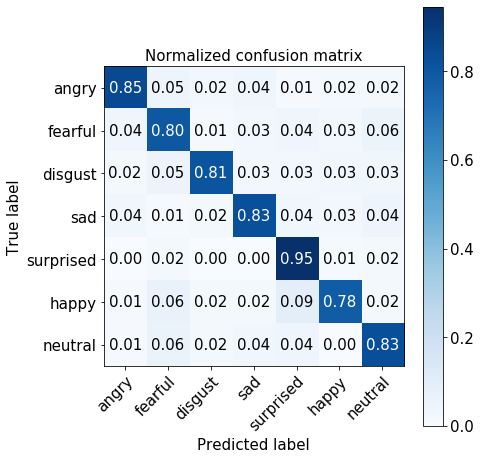

In [14]:
scoring_list = ['accuracy', 'balanced_accuracy','f1_micro','f1_macro','f1_weighted']
hyperparameters = {'boosting_type':['gbdt'],#gbdt, gbrt, rf, random_forest, dart, goss
                   #'model__class_weight':[],
                   #'model__colsample_bytree':[0.33,0.66,1],
                   #'model__importance_type':[],
                   #'model__learning_rate':[0.01],
                   'max_depth':[3,4],
                   'min_child_samples':[10,20,40], # Default 20
                   #'model__min_child_weight':[0.001], # Default 0.001
                   #'model__min_split_gain':[0], # Default 0
                   #'model__n_estimators':[100], # Default 100
                   #'model__n_jobs':[0], # Default 0. Num_threads
                   'num_leaves':[6,15,31,62], # Default 31
                   'objective':['binary'],
                   'random_state':[209],
                   'reg_alpha':[0,0.5,1], # Default 0
                   'reg_lambda':[0,0.5,1] # Default 0
                   #'model__silent':[], # No info
                   #'model__subsample':[1], # Default 1
                   #'model__subsample_for_bin':[], # Default 200000
                   #'model__subsample_freq':[0], # Default 0
                   
                   }
lgbm_grid_class = RandomizedSearchCV(estimator=LGBMClassifier(),
                             param_distributions=hyperparameters,
                             cv=3,
                             random_state=209,
                             scoring=scoring_list[3],
                             #n_iter=10,
                             verbose=1)
lgbm_grid_class.fit(X_train,y_train)

# Save Trained Model
with open('lgbm_grid_class.pkl', 'wb') as picklefile:
    pickle.dump(lgbm_grid_class, picklefile)

lgbm_grid_class.best_params_
various_scores(lgbm_grid_class,X_train,y_train,'Train')
various_scores(lgbm_grid_class,X_test,y_test,'Test')
plot_confusion_matrix((y_test),lgbm_grid_class.predict(X_test),classes=list(df_combined_processed['emotion_desc'].unique()),normalize=True);

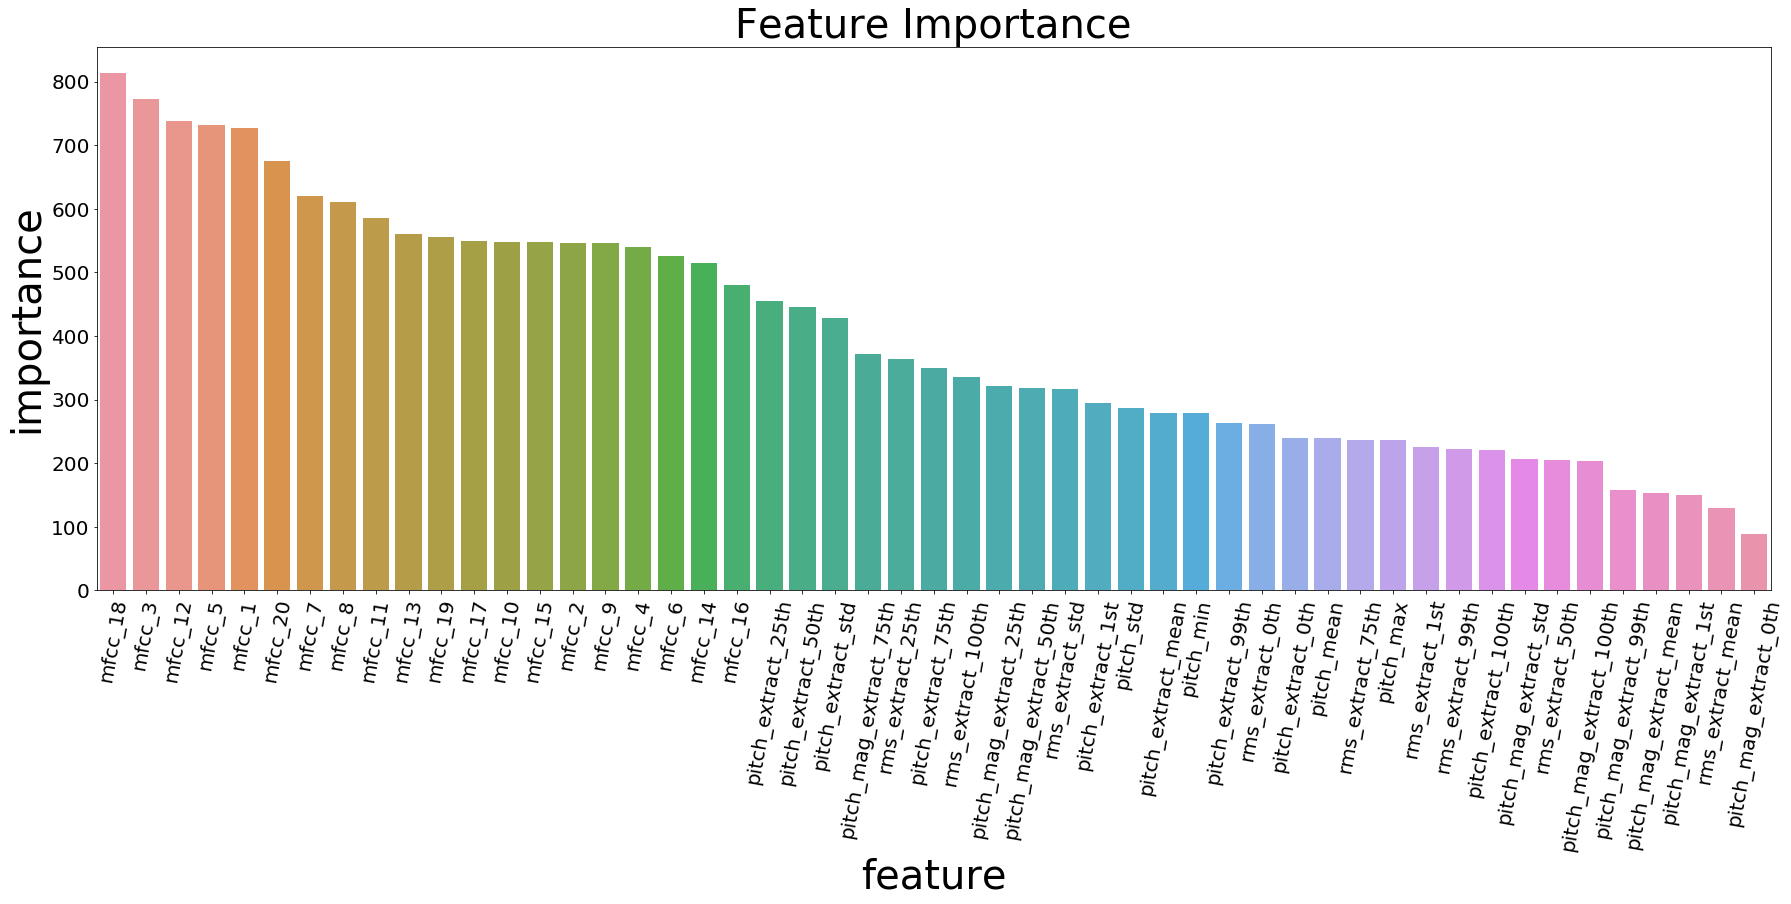

In [73]:
feature_importance = pd.DataFrame({'feature':X.columns,'importance':lgbm_grid_class.best_estimator_.feature_importances_})
feature_importance.sort_values(by='importance',ascending=False,inplace=True)

plt.figure(figsize=(30, 10))

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=40)     # fontsize of the axes title
plt.rc('axes', labelsize=40)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.rc('figure', titlesize=50)  # fontsize of the figure title
plt.title('Feature Importance')
plt.xticks(rotation=80)
sns.barplot(y=feature_importance['importance'],x=feature_importance['feature'])